In [1]:
import sys
sys.path.append('/vol/tensusers5/nhollain/s_clip_scripts')

from s_clip_scripts.data_loader import get_data, get_custom_data, TokenizedDataset, create_datainfo
from s_clip_scripts.tools import read_json
from collections import Counter
import pandas as pd
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from PIL import Image

foo = Image.open('./images/Sydney_example.png') 
width, height = foo.size  # 1500 x 1500
 
# downsize the image with an ANTIALIAS filter (gives the highest quality)
new_width, new_height = round(width/4), round(height/4)
foo = foo.resize((new_width,new_height))
 
foo.save('./images/Sydney_example_scaled.png', quality=85)
foo.save('./images/Sydney_example_scaled_opt.png', optimize=True, quality=85)

In [3]:
os.listdir('./data')

['sydney_captions',
 'scicap_data.zip',
 'polyvore',
 'scicap',
 'fashion200k',
 'UCM_captions.zip',
 'RSICD.zip',
 'polyvore-images.tar.gz',
 'RSICD',
 'UCM',
 'UCMerced_LandUse',
 'WHU-RS19',
 'RSSCN7',
 'AID',
 'NWPU-RESISC45',
 'kaggle_simpsons_characters.zip',
 'kaggle_simpsons_characters',
 'polyvore_outfits.zip',
 'polyvore_outfits',
 'fashiongen',
 'test',
 '.ipynb_checkpoints']

In [4]:
print(os.listdir('./data/RSICD'))

def load_captions(path: str, split: str):
        captions = read_json(path)["images"]
        return [c['filename'] for c in captions if c["split"] == split or len(split) == 0]

def plot_counts_rsicd(split):
    data = load_captions('./data/RSICD/dataset_rsicd.json', split)
    
    classes = []
    path2class = {}
    
    class_dir = './data/RSICD/txtclasses_rsicd'
    for idx, fn in enumerate(sorted(os.listdir(class_dir))):
        classes.append(fn.split(".txt")[0])
        with open(os.path.join(class_dir, fn)) as f:
            for line in f.readlines():
                path2class[line.strip()] = idx

    path2class = {key:path2class[key] for key in data}
    path2class_lst = list(path2class.values())
    paths = list(path2class.keys())
    labels, counts = np.unique(path2class_lst, return_counts=True)
    return labels, counts, paths
    # plt.title('RSICD label counts ({})'.format(split))
    # plt.ylabel('Count')
    # plt.bar(labels, counts, align='center')
    # plt.xticks(labels, rotation = 90)
    # plt.show()
    # return paths

train_labels, train_counts, train_paths = plot_counts_rsicd('train')
val_labels, val_counts, val_paths = plot_counts_rsicd('val')
test_labels, test_counts, test_paths = plot_counts_rsicd('test')
all_labels, all_counts, all_paths = plot_counts_rsicd('all')

print(len(set(test_paths).intersection(set(val_paths))))

['RSICD_images', 'dataset_rsicd.json', 'txtclasses_rsicd.rar', 'txtclasses_rsicd']
0


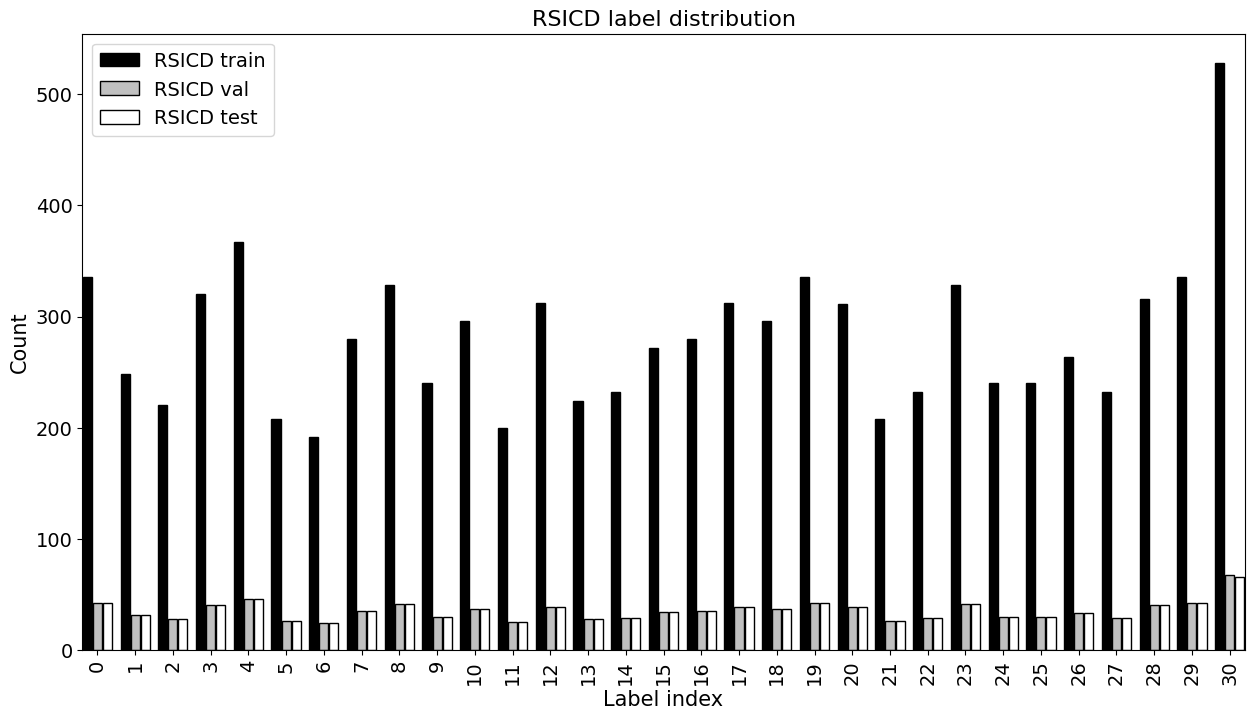

In [5]:
# From: https://stackoverflow.com/questions/14270391/how-to-plot-multiple-bars-grouped
def bar_plot_multiple(ax, data, colors=None, total_width=0.8, single_width=1, legend=True, font_size = 12):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data to plot. Keys = the names of the data, items = a list of the values.

        Example: data = {"x":[1,2,3], "y":[1,2,3], "z":[1,2,3]}

    colors : array-like, optional, default: None
        A list of colors to use for the bars. If None, the colors are the standard matplotlib color cyle. 

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars will touch each other 
        within a group, values less than 1 will make these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """
    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []
    heights_left_bar = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x+x_offset, y, width=bar_width*single_width, color=colors[i % len(colors)], edgecolor = "black")
            height = bar[0].get_height()
            width = bar[0].get_width()
            loc = bar[0].get_x()
            
            if i % 3 == 0:
                heights_left_bar.append(height)

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])
        
    # Draw legend if legend = True
    if legend:
        ax.legend(bars, data.keys(), fontsize = font_size, loc = 'upper left')
        
        
data = {'RSICD train': train_counts, 
        'RSICD val': val_counts,
        'RSICD test': test_counts}

# Resize figure, choose fontsize 
fig, ax = plt.subplots(figsize=(15, 8))
font_size = 14

# Plot the bars and significances
bar_plot_multiple(ax, data, total_width=.8, single_width=0.9, colors = ['black', 'silver', 'white'], font_size = font_size )


# Add text to the plot
plt.title('RSICD label distribution', fontsize = font_size + 2)
plt.xticks(range(train_labels.shape[0]), train_labels, rotation = 90, fontsize = font_size)
plt.yticks(fontsize = font_size)
plt.ylabel('Count', fontsize = font_size+1)
plt.xlabel('Label index', fontsize = font_size+1)
plt.xlim(min(train_labels)-0.4, max(train_labels)+0.4)

# Store the plot as a .png
# plt.savefig('./results/FPs_distance_property.png', bbox_inches = 'tight')
plt.show()

In [6]:
split_classes = []
for d in data:
    split_classes.append(path2class[d['filename']])
Counter(split_classes)

NameError: name 'path2class' is not defined

In [4]:
from itertools import chain
from s_clip_scripts.main import main
from s_clip_scripts.params import parse_args

fashion = False

if fashion:
    str_args = '''--train-data Fashion-ALL
            --label-ratio 0.1
            --val-data Fashion-ALL
            --keyword-path keywords/fashion/class-name.txt
            --epochs 10
            --method base  
    '''
else:
    str_args = ''' --train-data RS-ALL
            --label-ratio 0.1
            --val-data RS-ALL
            --imagenet-val RSICD-CLS \
            --keyword-path keywords/RS/class-name.txt
            --epochs 25
            --zeroshot-frequency 5  
            --method ours
            --use_vit
    '''
str_args = str_args.split('\n')
str_args = [s.strip() for s in str_args]
str_args = [s.split(' ') for s in str_args]
str_args = list(chain(*str_args))
str_args = [s for s in str_args if len(s) > 0]
args = parse_args(str_args)

ModuleNotFoundError: No module named 'open_clip'

In [ ]:
from open_clip import create_model_and_transforms, get_tokenizer, create_loss
from s_clip_scripts.model import create_custom_model
args.device = 'cuda:0' 
model, preprocess_train, preprocess_val = create_model_and_transforms(
        args.model, args.pretrained, precision=args.precision, device=args.device, output_dict=True,
        aug_cfg = args.aug_cfg, )
model = create_custom_model(args, model)
data = get_data(args, (preprocess_train, preprocess_val), tokenizer=get_tokenizer(args.model))

In [19]:
for img, target in iter(data['val'].dataloader):
    print(target)

tensor([[49406,   320,  2866,  ...,     0,     0,     0],
        [49406,  1346,  1579,  ...,     0,     0,     0],
        [49406,   320,  5363,  ...,     0,     0,     0],
        ...,
        [49406,   585,   533,  ...,     0,     0,     0],
        [49406,   585,   533,  ...,     0,     0,     0],
        [49406,   585,   533,  ...,     0,     0,     0]])
tensor([[49406,   320,  2754,  ...,     0,     0,     0],
        [49406,   585,   533,  ...,     0,     0,     0],
        [49406,   585,   533,  ...,     0,     0,     0],
        ...,
        [49406,  1573,   533,  ...,     0,     0,     0],
        [49406,   320,  2754,  ...,     0,     0,     0],
        [49406,  7882,   572,  ...,     0,     0,     0]])
tensor([[49406,   320,  3638,  ...,     0,     0,     0],
        [49406,  1573,   533,  ...,     0,     0,     0],
        [49406,  1579,  7882,  ...,     0,     0,     0],
        ...,
        [49406,   550, 15039,  ...,     0,     0,     0],
        [49406,   320,  3638,  

In [3]:
# PROBLEMS WITH POLYVORE DATA: the data structure seems to be different from what the S-CLIP paper uses.
# I want to probably get the dict['items'] values for each folder and then take the images from there.
working_datasets = ['RSICD', 'UCM', 'Sydney', 'Fashion200k', 'SciCap', 'RSICD-CLS', 'UCM-CLS', 'Fashion200k-CLS', 'WHU-RS19', 'RSSCN7', 
                    'AID', 'RESISC45', 'Simpsons-Images', 'Polyvore', 'Polyvore-CLS', 'FashionGen', 'FashionGen-CLS']
# get_custom_data(args, data, preprocess_fn, is_train, cls, subclass, **data_kwargs):
for dataset in working_datasets:
    print(dataset)
    cls = 'CLS' in dataset
    # CLS version of most datasets just uses the non-CLS dataloader, but adds cls = True as argument
    if dataset != 'UCM-CLS': # Exception: UCM-CLS is a different dataloader altogether than UCM!
        dataset = dataset.replace('-CLS', '')
    get_custom_data(None, data = dataset, preprocess_fn = None, is_train = True, cls = cls, subclass = False)

RSICD
UCM
Sydney
Fashion200k
SciCap
RSICD-CLS
UCM-CLS
Fashion200k-CLS
WHU-RS19
RSSCN7
AID
RESISC45


In [1]:
get_custom_data(None, data = 'Simpsons-Images', preprocess_fn = None, is_train = True, cls = True, subclass = False)

Dataset ImageFolder
    Number of datapoints: 20933
    Root location: ./data/kaggle_simpsons_characters/simpsons_dataset

In [6]:
%%time
from tools import read_json
path = './data/polyvore_outfits/disjoint'
split_info = read_json(os.path.join(path, 'train.json'))
path = './data/polyvore_outfits/polyvore_item_metadata.json'
metadata = read_json(path)

CPU times: user 1.32 s, sys: 192 ms, total: 1.51 s
Wall time: 1.51 s


In [11]:
%%time
split_item_ids = []
for grouping in split_info:
    items = grouping['items']
    item_ids = [item['item_id'] for item in items] # Get image IDs
    split_item_ids += item_ids
split_item_ids   

CPU times: user 15 ms, sys: 0 ns, total: 15 ms
Wall time: 14.9 ms


['132621870',
 '153967122',
 '171169800',
 '162799044',
 '172538912',
 '172312529',
 '162715806',
 '171888747',
 '173096665',
 '170904692',
 '172482221',
 '180028994',
 '182218570',
 '180850592',
 '179806210',
 '181657245',
 '165695205',
 '198643069',
 '206048471',
 '204007990',
 '200709959',
 '195973920',
 '200139640',
 '156489567',
 '148693800',
 '200313980',
 '204650506',
 '208870650',
 '207173723',
 '207871410',
 '208870252',
 '199376553',
 '203551771',
 '203552462',
 '175711802',
 '210942072',
 '212839321',
 '213855157',
 '207459533',
 '192511179',
 '187317072',
 '180362994',
 '191221027',
 '173097736',
 '172685140',
 '164453126',
 '169982065',
 '169809127',
 '213007746',
 '212992927',
 '214327110',
 '207668984',
 '181900351',
 '202212715',
 '209966118',
 '70625358',
 '208664157',
 '193455194',
 '211421142',
 '161180948',
 '158857944',
 '88909845',
 '119901618',
 '107732394',
 '166542899',
 '151124575',
 '133932837',
 '161950492',
 '210326667',
 '209505560',
 '50235496',
 '2006396

In [24]:
%%time
data = []
cls = False
item_keys = set(metadata.keys())
split_item_ids = set(split_item_ids)
intersect = item_keys.intersection(split_item_ids)
for item_key in intersect:
    # if item_key not in split_item_ids: # Skip items not in the current split
    #     continue
    item = metadata[item_key]
    item_path = item_key + '.jpg'
    if cls: # For classification, we use the (sub)category as the class label
        data.append({"image_path": item_path, "class_name": item["semantic_category"]}) 
    else: # For captions, we use the fashion item's title (=name) and description as its caption
        data.append({"image_path": item_path, "sentences": item["title"] + "." + item["description"]})

CPU times: user 193 ms, sys: 0 ns, total: 193 ms
Wall time: 192 ms


In [23]:
%%time
item_keys = list(metadata.keys())
len(set(item_keys)), len(set(split_item_ids)), len(item_keys), len(split_item_ids)
intersect = set(item_keys).intersection(set(split_item_ids))
len(intersect)

CPU times: user 85.7 ms, sys: 0 ns, total: 85.7 ms
Wall time: 85.3 ms


71967

In [ ]:
# 200 ms